In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 
import seaborn as sns
from collections import ChainMap
from collections import Counter
from datetime import datetime
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn.model_selection import train_test_split  # Загружаем специальный инструмент для разбивки: 
from statsmodels.stats import weightstats

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [46]:
main_task = pd.read_csv('main_task.csv')

In [47]:
#  предобработка
# для удобства переименуем переменные
main_task.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
              'price_range', 'number_of_reviews', 'reviews', 'URL_TA', 'ID_TA']

df = main_task.copy()

def price_range_convector(raw):
    
    if raw == '$$ - $$$':
        return 2
    elif raw == '$':
        return 1
    elif raw == '$$$$':
        return 3
    

def outliers_check(sample):
    ''' The function takes Pandas.Series
        then calculate outliers 
        and return df with them '''

    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1
    temp_df = pd.DataFrame(sample)
    temp_df['up_outliers'] = pd.Series(sample > (Q3 + IQR*1.5))
    temp_df['down_outliers'] = pd.Series(sample < (Q1 - IQR*1.5))

    if temp_df.up_outliers.nunique() == 1 and temp_df.down_outliers.nunique() == 1:
        return print('Выбросы не найдены')
    else:
        return temp_df[(temp_df.down_outliers == True) | (temp_df.up_outliers == True)]
    
    
def outliers_replace(sample):
    ''' The function takes Pandas.Series
        then calculate outliers 
        and return df with them '''
    sample = df_.delta_reviews_time.copy()
    Q1 = sample.quantile(0.25)
    Q3 = sample.quantile(0.75)
    IQR = Q3 - Q1
    temp_df = pd.DataFrame(sample)
    temp_df['up_outliers'] = pd.Series(sample > (Q3 + IQR*1.5))
    temp_df['down_outliers'] = pd.Series(sample < (Q1 - IQR*1.5))
    to_replace = list(set(outliers_check(sample)[temp_df.columns[0]]))
    mediana = temp_df[temp_df.columns[0]].median()    
    temp_df = temp_df.replace(to_replace, mediana)
    
    return temp_df[temp_df.columns[0]]


def standartization(series):
    '''standartization of pd.Series'''
    centr = series - series.mean()
    return centr / np.linalg.norm(centr)


def return_count(value):
    if type(value) == list:
        return len(value)
    else: return 1
    
    
def capital_check(raw):
    
    capital = ['Paris', 'Stockholm', 'London', 'Berlin',
           'Bratislava', 'Vienna', 'Rome', 'Madrid',
           'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
           'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
           'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']
    non_capital = ['Munich', 'Oporto', 'Milan', 'Barcelona', 'Zurich', 
                   'Lyon', 'Hamburg', 'Edinburgh', 'Geneva', 'Krakow']
    
    if raw in capital: 
        return 1
    else:
        return 0


*  Restaurant_id — идентификационный номер ресторана / сети ресторанов;
*   City — город, в котором находится ресторан;
*  Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
*  Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
*    Price Range — диапазон цен в ресторане;
*   Number of Reviews — количество отзывов о ресторане;
*  Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.


На первом этапе для создания такого датафрейма давайте просто удалим столбцы, содержащие данные типа __object__, и заполним пропущенные значения (__None__ или __NaN__) каким-то одним значением (нулём или средним арифметическим) для всего столбца.

In [48]:
#  удалим все нечисловые колонки

# df_1 = df_1.drop([column  for column in df_1.columns if df_1[column].dtype == 'O'],axis=1)
# df_1.number_of_reviews = df_1.number_of_reviews.fillna(0)
# display(df_1.info())
# df[df_1.number_of_reviews.isna()]  # выведем все нулевые значения

нулевых значений нет

In [49]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = df.drop(['restaurant_id', 'rating'], axis = 1)  
# X = df_1.drop(['rating'], axis = 1)  

# y = df_1['rating']  
      
    # Загружаем специальный инструмент для разбивки:  убрано наверх
#     from sklearn.model_selection import train_test_split   
    
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
    # Для тестирования мы будем использовать 25% от исходного датасета.  
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    

In [50]:
# Импортируем необходимые библиотеки: убрано наверх 
#     from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
#     from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
# regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
# regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
# y_pred = regr.predict(X_test)  

In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
# print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

 4.1 Вопросы о ценах

Сколько вариантов непустых значений встречается в столбце Price Range?

In [52]:
# df_4 = main_task.copy()

In [53]:
# variants = [element for element in(df.price_range.unique()) if type(element) == str]
# display(len(variants),variants)

In [54]:
df.sample()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,URL_TA,ID_TA
20327,id_10403,Paris,['Greek'],10405.0,4.0,$$ - $$$,19.0,"[['Good quality, good service take away', 'Exc...",/Restaurant_Review-g187147-d6995931-Reviews-Ev...,d6995931


Сколько ресторанов относятся к среднему ценовому сегменту?

In [55]:
# len(df[df.price_range == '$$ - $$$'])

 4.2 Вопрос о городах  
1 point possible (graded)  
Сколько городов представлено в наборе данных?

In [56]:
# len(df.city.unique())

## 4.3 Вопросы о кухнях

Сколько типов кухонь представлено в наборе данных?

In [57]:
# df = main_task.copy()
# df.cuisine_style = df.cuisine_style.str.replace("'", '')
# df.cuisine_style = df.cuisine_style.str.replace("[", '')
# df.cuisine_style = df.cuisine_style.str.replace("]", '')
# df.cuisine_style = df.cuisine_style.str.replace(" ", '')
# df.cuisine_style = df.cuisine_style.str.split(',')
# df = df.explode('cuisine_style')
# df.head()

In [58]:
# df_4 = main_task.copy()

# df_4.cuisine_style = df_4.cuisine_style.str.strip("'' []")
# display(type(df_4.cuisine_style.loc[0]))
# df_4.cuisine_style.loc[0]

In [59]:
# cuisine = [element for element in (df.cuisine_style.unique()) if type(element) == str]
# display(len(cuisine))
# df.cuisine_style.value_counts()

Какое среднее количество кухонь предлагается в одном ресторане? Если в данных отсутствует информация о типах кухонь, то считайте, что в этом ресторане предлагается только один тип кухни. Ответ округлите до одного знака после запятой.

In [60]:
# df4 = main_task.copy()
# df4.cuisine_style = df4.cuisine_style.str.replace("'", '')
# df4.cuisine_style = df4.cuisine_style.str.replace("[", '')
# df4.cuisine_style = df4.cuisine_style.str.replace("]", '')
# df4.cuisine_style = df4.cuisine_style.str.replace(" ", '')
# df4.cuisine_style = df4.cuisine_style.str.split(',')

# def return_count(value):
#     if type(value) == list:
#         return len(value)
#     else: return 1
# df4['cuisine_number'] = df4.cuisine_style.apply(return_count)
# round(df4.cuisine_number.mean(),1)

## 4.4 Вопросы об отзывах

Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.


In [61]:
df = main_task.copy()

In [62]:
pattern = re.compile('\d+\W\d+\W\d\d\d\d')
df['reviews_date'] = df.reviews.apply(lambda x: pattern.findall(str(x)))

In [63]:
r_date = pd.DataFrame(df.reviews_date.explode())
r_date.reviews_date = pd.to_datetime(r_date.reviews_date)

Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на сайте ресторана? Введите количество дней в виде целого числа.

In [64]:
first_review = r_date.groupby(r_date.index).min()
last_review = r_date.groupby(r_date.index).max()
delta_time = last_review - first_review
# delta_time.max()

# Добавим к датафрейму три переменные: время публикации последнего отзыва, время публиккации предпоследнего отзыва и разницу в днях между ними.

In [65]:
df['delta_reviews_time'] = delta_time.reviews_date
df['first_review_time'] = first_review.reviews_date
df['last_review_time'] = last_review.reviews_date

df.reviews.loc[df.delta_reviews_time == df.delta_reviews_time.max()]
# display(df.sample())
# df.info()

7990    [['Incredible buffet!', 'Used to be great, but...
Name: reviews, dtype: object

# Приведём переменную delta_reviews_time из типа pandas._libs.tslibs.timedeltas.Timedelta в int

In [66]:
df_ = df.copy()
df_.delta_reviews_time = df_.delta_reviews_time.apply(lambda x: str(x)).str.split(' ',expand=True)
df_.delta_reviews_time = df_.delta_reviews_time.replace('NaT',0) # здесь пустые значения мы заменяем на ноль.
df_.delta_reviews_time = df_.delta_reviews_time.astype(int)

# # ниже мы заменяем ноли на медиану высчитанную без учёта нолей.
# mediana = df_[df_.delta_reviews_time !=0].delta_reviews_time.median()
# df_.delta_reviews_time = df_.delta_reviews_time.replace(0,mediana) # оказалось вредным.

df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   restaurant_id       40000 non-null  object        
 1   city                40000 non-null  object        
 2   cuisine_style       30717 non-null  object        
 3   ranking             40000 non-null  float64       
 4   rating              40000 non-null  float64       
 5   price_range         26114 non-null  object        
 6   number_of_reviews   37457 non-null  float64       
 7   reviews             40000 non-null  object        
 8   URL_TA              40000 non-null  object        
 9   ID_TA               40000 non-null  object        
 10  reviews_date        40000 non-null  object        
 11  delta_reviews_time  40000 non-null  int64         
 12  first_review_time   33529 non-null  datetime64[ns]
 13  last_review_time    33529 non-null  datetime64

# посчитаем количество кухонь Cuisine style

In [67]:
df_.loc[0, 'cuisine_style']

"['European', 'French', 'International']"

In [68]:
df_.cuisine_style = df_.cuisine_style.fillna("['mystery']")
df_.cuisine_style = df_.cuisine_style.apply(lambda x: eval(x))

In [69]:
df_.loc[0, 'cuisine_style']

['European', 'French', 'International']

In [70]:
df_['n_cuisine'] = df_.cuisine_style.apply(lambda x: len(x))
df_.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,URL_TA,ID_TA,reviews_date,delta_reviews_time,first_review_time,last_review_time,n_cuisine
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",41,2017-11-20,2017-12-31,3
1,id_1535,Stockholm,[mystery],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",382,2016-06-19,2017-07-06,1



* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.



# number_of_reviews

In [71]:
# df_[df_.number_of_reviews.isna()]

In [72]:
df_.number_of_reviews = df_.number_of_reviews.fillna(0) # заполнение пропусков нолями

# city 	

In [73]:
df_['capital'] = df.city.apply(capital_check)
df_.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,URL_TA,ID_TA,reviews_date,delta_reviews_time,first_review_time,last_review_time,n_cuisine,capital
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",41,2017-11-20,2017-12-31,3,1
1,id_1535,Stockholm,[mystery],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",382,2016-06-19,2017-07-06,1,1


# reviews

In [74]:

# df_.reviews[df.reviews.str.find]

# средний ранг по городу

In [75]:
# средний ранг по городу
mean_city_ranking = df_.groupby('city').ranking.mean()
mean_city_ranking

city
Amsterdam     1580.943831
Athens         881.108280
Barcelona     3914.144111
Berlin        3266.237123
Bratislava     453.112957
Brussels      1535.347170
Budapest      1220.811275
Copenhagen     974.699545
Dublin         983.725111
Edinburgh      873.041946
Geneva         708.286902
Hamburg       1355.140148
Helsinki       566.909574
Krakow         614.553047
Lisbon        1877.126154
Ljubljana      239.907104
London        8198.461873
Luxembourg     313.719048
Lyon          1307.559417
Madrid        4388.423102
Milan         3098.143929
Munich        1370.539754
Oporto         738.473684
Oslo           568.288312
Paris         6933.012048
Prague        2077.387387
Rome          2983.397498
Stockholm     1242.386585
Vienna        1706.102058
Warsaw        1063.039890
Zurich         782.486989
Name: ranking, dtype: float64

In [76]:
def mean_city_ranking_create(city):
    return mean_city_ranking.loc[city]

In [77]:
df_['mean_city_ranking'] = df_.city.apply(mean_city_ranking_create)

In [78]:
city = 'Paris'
mean_city_ranking.loc[city]

6933.012048192771

In [79]:
df_.head(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,URL_TA,ID_TA,reviews_date,delta_reviews_time,first_review_time,last_review_time,n_cuisine,capital,mean_city_ranking
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"[12/31/2017, 11/20/2017]",41,2017-11-20,2017-12-31,3,1,6933.012048
1,id_1535,Stockholm,[mystery],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[07/06/2017, 06/19/2016]",382,2016-06-19,2017-07-06,1,1,1242.386585


# Нормированный на количество ресторанов в городе ранг.

In [80]:
# Нормированный на количество ресторанов в городе ранг.
number_of_restaurants  = df_.city.value_counts()
number_of_restaurants

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

In [81]:
def normalized_ranking(city):
    return number_of_restaurants.loc[city]

In [82]:
df_['n_restaurants_per_city'] = df_.city.apply(normalized_ranking)

In [83]:
df_['ranking_per_n_r_city'] = df_.ranking / df_.n_restaurants_per_city

# restaurant_id

In [84]:
df_.restaurant_id.value_counts()

id_871      18
id_227      18
id_436      18
id_633      18
id_344      17
            ..
id_14435     1
id_11574     1
id_14325     1
id_10736     1
id_9367      1
Name: restaurant_id, Length: 11909, dtype: int64

Много дублей в restaurant_id. Выделим числовую часть из строки.

In [85]:
df_.restaurant_id = df_.restaurant_id.str.replace('id_', '')
df_.sample(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,URL_TA,ID_TA,reviews_date,delta_reviews_time,first_review_time,last_review_time,n_cuisine,capital,mean_city_ranking,n_restaurants_per_city,ranking_per_n_r_city
26472,618,Edinburgh,"[Cafe, Asian, Tibetan, Vegetarian Friendly, Ve...",619.0,4.5,$,69.0,"[['Simple Food Served Simply!', 'amazing dumpl...",/Restaurant_Review-g186525-d6623139-Reviews-Hi...,d6623139,"[10/11/2017, 10/08/2017]",3,2017-10-08,2017-10-11,6,0,873.041946,596,1.038591
12292,822,Stockholm,"[Mediterranean, Spanish]",823.0,4.0,$$ - $$$,38.0,"[['There are better places', 'Spain open to yo...",/Restaurant_Review-g189852-d5449751-Reviews-La...,d5449751,"[09/04/2016, 08/29/2016]",6,2016-08-29,2016-09-04,2,1,1242.386585,820,1.003659


In [86]:
df_.restaurant_id = df_.restaurant_id.astype(int)
df_.restaurant_id.loc[0]

5569

# средний ранг по сети

In [87]:
mean_net_restaurant = df_.groupby('restaurant_id').ranking_per_n_r_city.mean()
mean_net_restaurant

restaurant_id
0        0.001101
1        0.003212
2        0.004676
3        0.006612
4        0.008148
           ...   
16401    2.852180
16414    2.854785
16416    2.855133
16419    2.855828
16422    2.856349
Name: ranking_per_n_r_city, Length: 11909, dtype: float64

In [88]:
def mean_net_ranking(value):
    return mean_net_restaurant.loc[value]


In [89]:
df_['mean_net_ranking'] = df_.restaurant_id.apply(mean_net_ranking)

In [90]:
df_.sample(2)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,URL_TA,ID_TA,reviews_date,delta_reviews_time,first_review_time,last_review_time,n_cuisine,capital,mean_city_ranking,n_restaurants_per_city,ranking_per_n_r_city,mean_net_ranking
24149,2320,Berlin,[mystery],2322.0,4.5,NaN,15.0,[['Our favourite coffee place around the corn....,/Restaurant_Review-g187323-d7991223-Reviews-Na...,d7991223,"[10/03/2017, 07/13/2017]",82,2017-07-13,2017-10-03,1,1,3266.237123,2155,1.077494,1.733616
35892,872,Paris,"[French, European, Vegetarian Friendly]",873.0,4.5,$$ - $$$,275.0,"[['Good food specially presented', 'Very nice'...",/Restaurant_Review-g187147-d2545051-Reviews-Le...,d2545051,"[12/27/2017, 12/06/2017]",21,2017-12-06,2017-12-27,3,1,6933.012048,4897,0.178272,1.208686


# Сеть ресторанов

In [91]:
r_net = df_.restaurant_id.value_counts()

In [92]:
def net_creator(value):
    if r_net.loc[value] == 1:
        return 0
    else: return 1

In [93]:
# r_net.loc[1511]

In [94]:
df_['net'] = df_.restaurant_id.apply(net_creator)

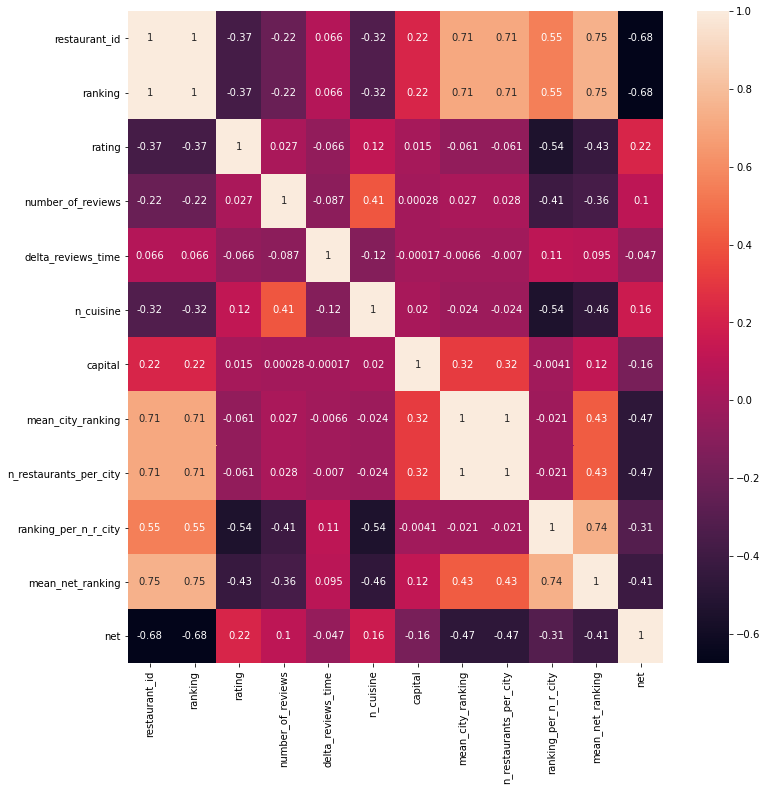

In [95]:
sns.heatmap(df_.corr(), annot=True)
plt.gcf().set_size_inches(12, 12)

In [96]:
df_ = df_.drop(['n_restaurants_per_city','restaurant_id'],axis=1)

# dummy для кухонь

In [97]:
df_ = df_.join(pd.get_dummies(df_.cuisine_style.apply(pd.Series).stack()).sum(level=0))

df_.sample()

,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,URL_TA,ID_TA,reviews_date,delta_reviews_time,first_review_time,last_review_time,n_cuisine,capital,mean_city_ranking,ranking_per_n_r_city,mean_net_ranking,net,Afghani,African,Albanian,American,Arabic,Argentinean,...,South American,Southwestern,Spanish,Sri Lankan,Steakhouse,Street Food,Sushi,Swedish,Swiss,Taiwanese,Thai,Tibetan,Tunisian,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan,mystery
14343,Geneva,"[French, European, Cafe]",302.0,4.5,$$ - $$$,43.0,"[['Excellent lunch', 'Amazing flavours'], ['10...",/Restaurant_Review-g188057-d4602819-Reviews-Ca...,d4602819,"[10/20/2016, 02/24/2016]",239,2016-02-24,2016-10-20,3,0,708.286902,0.627859,0.522432,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
display(df_.cuisine_style.explode().unique())
display(df_.cuisine_style.explode().value_counts())

array(['European', 'French', 'International', 'mystery', 'Japanese',
       'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options',
       'Gluten Free Options', 'German', 'Central European', 'Italian',
       'Pizza', 'Fast Food', 'Mediterranean', 'Spanish', 'Healthy',
       'Cafe', 'Thai', 'Vietnamese', 'Bar', 'Pub', 'Chinese', 'British',
       'Polish', 'Fusion', 'Dutch', 'Mexican', 'Venezuelan',
       'South American', 'Soups', 'Belgian', 'Steakhouse', 'Latin',
       'Barbecue', 'Argentinean', 'Irish', 'Seafood', 'Swiss',
       'Portuguese', 'Contemporary', 'Wine Bar', 'Greek',
       'Central American', 'Indian', 'Middle Eastern', 'Turkish',
       'Hungarian', 'Pakistani', 'Peruvian', 'Delicatessen',
       'Eastern European', 'Swedish', 'Scandinavian', 'Tibetan', 'Nepali',
       'Korean', 'Southwestern', 'Czech', 'American', 'Slovenian',
       'Balti', 'Street Food', 'Diner', 'Brew Pub', 'Caribbean',
       'Austrian', 'Moroccan', 'Halal', 'Lebanese', 'Russian'

Vegetarian Friendly    11189
European               10060
mystery                 9283
Mediterranean           6277
Italian                 5964
                       ...  
Xinjiang                   1
Yunnan                     1
Latvian                    1
Salvadoran                 1
Burmese                    1
Name: cuisine_style, Length: 126, dtype: int64

# Приведём Price Range в dummy переменные


In [99]:
# заменим NaN на моду
df_.price_range = df_.price_range.fillna(df_.price_range.mode()[0])
# Price Range в dummy переменные
price_range_dummy = pd.get_dummies(df_.price_range)
df_ = df_.join(price_range_dummy)

# dummy для городов

In [114]:
# city в dummy переменные
city_dummy = pd.get_dummies(df_.city)
df_ = df_.join(city_dummy)

# Стандартизация признаков

Пока что даёт плохой результат


In [100]:
# # стандартизация number_of_reviews
# df_['number_of_reviews_st'] = standartization(df_.number_of_reviews)
# df_ = df_.drop('number_of_reviews', axis=1)
# df_.sample()

In [101]:
# # стандартизация ranking
# df_['ranking_st'] = standartization(df_.ranking)
# df_ = df_.drop('ranking', axis=1)
# df_.sample()

In [102]:
# # стандартизация price_range
# df_['price_range_st'] = standartization(df_.price_range)
# df_ = df_.drop('price_range', axis=1)
# df_.sample()

In [103]:
# # стандартизация n_cuisine
# df_['n_cuisine_st'] = standartization(df_.n_cuisine)
# df_ = df_.drop('n_cuisine', axis=1)
# df_.sample()

In [104]:
# # стандартизация delta_reviews_time
# df_['d_reviews_time_st'] = standartization(df_.delta_reviews_time)
# df_ = df_.drop('delta_reviews_time', axis=1)
# df_.sample()

# Проверим, что получилось с текущими изменениями

In [115]:
df_test = df_.copy()
df_test = df_test.drop([column  for column in df_test.columns if df_test[column].dtype == 'O' or df_test[column].dtype == '<M8[ns]'],axis=1)

display(df_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 170 entries, ranking to Zurich
dtypes: float64(6), int64(4), uint8(160)
memory usage: 9.2 MB


None

In [118]:
df_test.sample(5)

,ranking,rating,number_of_reviews,delta_reviews_time,n_cuisine,capital,mean_city_ranking,ranking_per_n_r_city,mean_net_ranking,net,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,Azerbaijani,Balti,Bangladeshi,Bar,Barbecue,...,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
20665,123.0,4.5,149.0,84,2,0,708.286902,0.255717,0.206480,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19462,9552.0,5.0,2.0,567,1,1,8198.461873,1.659197,1.659197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11210,635.0,4.0,31.0,184,2,0,738.473684,1.237817,0.760177,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
24089,2708.0,4.5,137.0,5,5,1,8198.461873,0.470384,0.763575,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6682,593.0,5.0,0.0,0,1,1,568.288312,1.540260,0.901126,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [107]:
sns.heatmap(df_test.corr(), annot=True)
plt.gcf().set_size_inches(12, 12)

ValueError: 
$$$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$$$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 432x288 with 2 Axes>

In [ ]:
# df_test = df_test.drop(['n_restaurants_per_city'],axis=1)

In [117]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = df.drop(['restaurant_id', 'rating'], axis = 1)  
X = df_test.drop(['rating'], axis = 1)  

y = df_test['rating']  
      
    # Загружаем специальный инструмент для разбивки:  убрано наверх
#     from sklearn.model_selection import train_test_split   
    
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
    # Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


# Импортируем необходимые библиотеки: убрано наверх 
#     from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
#     from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test) 

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

MAE: 0.20866550000000003


MAE: 0.38354679126984126 с признаком таймдельта и количество кухонь   
MAE: 0.3548893619047619 со столицами  
MAE: 0.21659699999999998 ranking, rating, price_range, number_of_reviews. delta_reviews_time, n_cuisine, capital mean_city_ranking, number_of_restaurants, normalized_ranking  
MAE: 0.216937 ranking,rating,price_range,number_of_reviews,delta_reviews_time,n_cuisine,capital,mean_city_ranking,normalized_ranking   
MAE: 0.21472799999999997 добавил dummy по диапазону цен и кухням.  
MAE: 0.20866550000000003 добавил dummy по городам   
 

In [ ]:
# # Check most important Features
# plt.rcParams['figure.figsize'] = (10,10)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')